# Graph Tool Sanbox

In [1]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from Functions import *
from Segregation import *
 
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from forceatlas2 import forceatlas2_networkx_layout

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
from importlib import reload


/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5), (5, 4)]
This are our toy weights [8, 9, 7, 10, 12, 11, 1, 2]


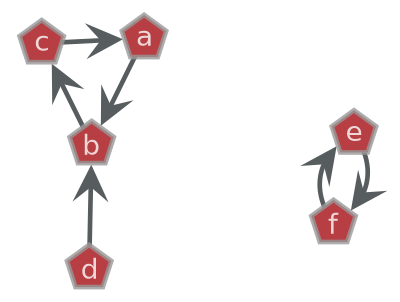

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f80dbaaf690, at 0x7f80dbadb890>

In [52]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5),(5,4)]
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11,1,2]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              #vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

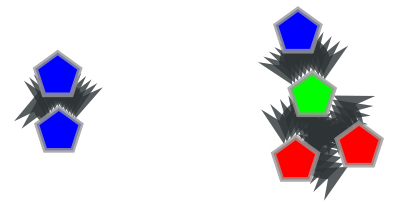

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f80db67d250, at 0x7f80dd9dee10>

In [32]:
# Create a graph layout and drawing
pos = gt.sfdp_layout(u)

gt.graph_draw(u,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=u.vp['Color'], # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

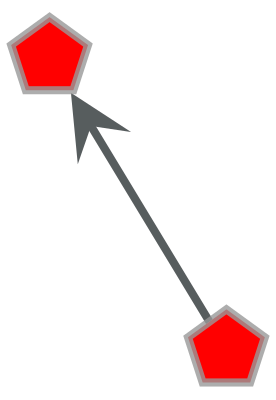

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f12e48fc910, at 0x7f12e437c690>

In [5]:
subgraph = filter_graph(g,'d')

gt.graph_draw(subgraph,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [6]:
# FUNCTION TESTING
print('Adjacency Matrix (Can have weights or be simple 1-0)')
print(get_adjacency(g))
print(' ')
print('Nodes')
print(g.get_vertices())
print(' ')
print('Types Array')
print(get_types_array(g,types='Political Label'))
print(' ')
print('Types Dictionary')
print(get_types_dict(g,types='Political Label'))
print(' ')
print('Types Index Dictionary')
print(get_types_index(g,types='Political Label'))
print(' ')
print('Types Matrix (A column is one of the arrays in the Types Dictionary)')
print(get_types_matrix(g,types='Political Label'))
print(' ')
print('Contact Layer')
print(get_contact_layer(g,types='Political Label'))
print(' ')
print('Non Contact Layer')
print(get_non_contact_layer(g,types='Political Label'))
print(' ')
print('Me Vs Others (Contact Layer considering one group Against all others) for Derecha')
print(me_vs_others(get_contact_layer(g,types='Political Label'), get_types_index(g,types='Political Label')['d'] ))

Adjacency Matrix (Can have weights or be simple 1-0)
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]
 
Nodes
[0 1 2 3 4 5]
 
Types Array
['d' 'c' 'd' 'i' 'i' 'i']
 
Types Dictionary
{'c': [0, 1, 0, 0, 0, 0], 'd': [1, 0, 1, 0, 0, 0], 'i': [0, 0, 0, 1, 1, 1]}
 
Types Index Dictionary
{'c': 0, 'd': 1, 'i': 2}
 
Types Matrix (A column is one of the arrays in the Types Dictionary)
[[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
 
Contact Layer
[[0. 1. 0.]
 [1. 1. 0.]
 [1. 0. 2.]]
 
Non Contact Layer
[[0. 1. 3.]
 [1. 1. 6.]
 [2. 6. 4.]]
 
Me Vs Others (Contact Layer considering one group Against all others) for Derecha
[[1. 1.]
 [1. 3.]]
